* This notebook provides the simulation experiment of the research work: COSS.
* Note that some margin differences between the notebook result and paper result but it didn't change the conclusion in the paper.

In [1]:
from itertools import cycle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random


# Tool Functions
* `perform_t_test`: Indenpendent Samples t-test using the function: stats.ttest_ind in scipy
* `perform_paired_t_test`: paried Samples t-test using the function: stats.ttest_rel in scipy
* `get_adjusted_metrics`: get adjusted metrincs by appling CUPED

In [2]:
from scipy import stats

def perform_t_test(group, metrics, variant_col='variant'):
    control = group[group[variant_col] == 'control']
    treatment = group[group[variant_col] == 'test']

    result = {}

    for metric in metrics:
        t_val, p_val = stats.ttest_ind(control[metric], treatment[metric], equal_var=False, nan_policy='omit')
        result[f'{metric}_t_val'] = t_val
        result[f'{metric}_p_val'] = p_val

    return pd.Series(result)

In [3]:
from scipy import stats

def perform_paired_t_test(
    group,
    metrics,
    variant_index_col='variant_index',
    variant_col='variant',
    randomization=False,
    random_seed=1):
  result = {}

  for metric in metrics:
    if randomization:
      control_metric = group[group[variant_col] == 'control'][metric].values
      random.seed(1+random_seed)
      random.shuffle(control_metric)
      treatment_metric = group[group[variant_col] == 'test'][metric].values
      random.seed(2+random_seed)
      random.shuffle(treatment_metric)
    else:
      control_metric = group[group[variant_col] == 'control'].sort_values(variant_index_col)[metric]
      treatment_metric = group[group[variant_col] == 'test'].sort_values(variant_index_col)[metric]

    t_val, p_val = stats.ttest_rel(control_metric, treatment_metric)
    result[f'{metric}_t_val'] = t_val
    result[f'{metric}_p_val'] = p_val

  return t_val, p_val

In [4]:
# CUPED to get adjusted metrics
def get_adjusted_metrics(df, target_metric, covariate):
    df_cov = df[[target_metric, covariate]].cov()
    df_corr = df[[target_metric, covariate]].corr()
    covariance = df_cov.loc[covariate, target_metric]
    correlation = df_corr.loc[covariate, target_metric]
    var_covariate = df_cov.loc[covariate, covariate]
    theta = covariance / var_covariate
    covariate_mean = df[covariate].mean()
    adjusted_metrics = df[target_metric] - (df[covariate] - covariate_mean) * theta
    # print("covariance:", covariance)
    # print("theta:", theta)
    # print("variance of the target metric:", df_cov.loc[target_metric, target_metric])
    # print("variance of the adjusted metric:", adjusted_metrics.var())
    # print("correlation between target metric and covariant:", correlation)
    # print("var*(1- corr^2):", df_cov.loc[target_metric, target_metric] * ( 1- correlation**2))
    return adjusted_metrics, correlation

# Generate the population Dataset

In [5]:
SAMPLE_SIZE = 200
POPULATION = 10000
a = 1
b = 2
c = 1

# Generate x values
np.random.seed(100)
x = np.linspace(-6, 4, POPULATION)

# Linear Relationship
linear_y_0 = b * x + c + np.random.normal(0, 1, POPULATION)
linear_y_0_without_noise = b * x + c

linear_y_1 = b * x + c + np.random.normal(1, 3, POPULATION)
linear_y_1_without_noise = b * x + c + 1


# Quadratic Relationship
quadratic_y_0 = a * x**2 + b * x + c + np.random.normal(0, 1, POPULATION)
quadratic_y_0_without_noise = a * x**2 + b * x + c

quadratic_y_1 = a * x**2 + b * x + c + np.random.normal(1, 3, POPULATION)
quadratic_y_1_without_noise = a * x**2 + b * x + c + 1


In [6]:
df_linear_population = pd.DataFrame({"x": x, "y_0": linear_y_0, "y_1": linear_y_1})
df_quadratic_population = pd.DataFrame({"x": x, "y_0": quadratic_y_0, "y_1": quadratic_y_1})

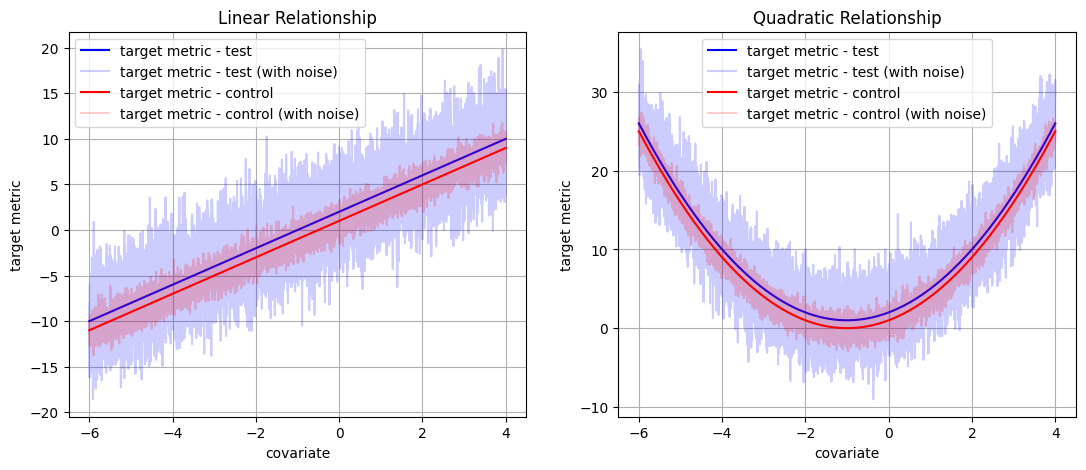

In [7]:
fig, axs = plt.subplots(1, 2,figsize=(13,5))
axs[0].plot(x, linear_y_1_without_noise, 'b-', label="target metric - test", alpha=1)
axs[0].plot(x, linear_y_1, 'b-', label="target metric - test (with noise)", alpha=0.2)

axs[0].plot(x, linear_y_0_without_noise, 'r-', label="target metric - control", alpha=1)
axs[0].plot(x, linear_y_0, 'r-', label="target metric - control (with noise)", alpha=0.2)

axs[0].set_xlabel('covariate')
axs[0].set_ylabel('target metric')
axs[0].set_title('Linear Relationship')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(x, quadratic_y_1_without_noise, 'b-', label="target metric - test", alpha=1)
axs[1].plot(x, quadratic_y_1, 'b-', label="target metric - test (with noise)", alpha=0.2)
axs[1].plot(x, quadratic_y_0_without_noise, 'r-', label="target metric - control", alpha=1)
axs[1].plot(x, quadratic_y_0, 'r-', label="target metric - control (with noise)", alpha=0.2)

axs[1].set_xlabel('covariate')
axs[1].set_xlabel('covariate')
axs[1].set_ylabel('target metric')
axs[1].set_title('Quadratic Relationship')
axs[1].grid(True)
axs[1].legend()
plt.show()

# Distribution of the average causal effect
We randomly sampled 200 data points from the population 5,000 times. We applied COSS to allocate the variants
for each sample and calculated the average effect ∆. We did the same with RCT and CUPED settings.

## Quadratic Relationship



### RCT(original)

In [8]:
y_list = []
# p_val_list = []
for i in range(5000):
  df_sampled = df_quadratic_population.sample(SAMPLE_SIZE, replace=True, random_state=i+123456).sort_values('x')
  # Combine the lists
  random_variants = ['test'] * (SAMPLE_SIZE//2) + ['control'] * (SAMPLE_SIZE//2)
  random.seed(145 + i)
  # Shuffle the combined list
  random.shuffle(random_variants)
  df_sampled["variant"] = random_variants
  df_sampled['y'] = df_sampled.apply(lambda x: x['y_1'] if x['variant']=='test' else x['y_0'], axis=1)
  df_sampled = df_sampled.reset_index(drop=True)
  # t_val, p_val = perform_t_test(df_sampled, metrics=['y'], )
  # p_val_list.append(p_val)
  mean_y = df_sampled.groupby('variant').y.mean()
  lift_y = mean_y.loc['test'] - mean_y.loc['control']
  y_list.append(lift_y)
lift_mean = sum(y_list) / len(y_list)
std = np.sqrt(statistics.variance(y_list))
print("sample mean: ", lift_mean)
print("std error: ", std)


sample mean:  0.9930008483684638
std error:  1.118577714562448


In [9]:
rct_stats = {'strategy': "RCT(original)" ,'lift_mean':  lift_mean, "std_error": std}
ser_rct_res = pd.Series(y_list)
rct_p_value = sum([y<=0 or y >= lift_mean * 2 for y in y_list]) / len(y_list)
print('p_value of RCT(original):', rct_p_value)

p_value of RCT(original): 0.3766


### RCT(CUPED)

In [10]:
y_list = []
# p_val_list = []
for i in range(5000):
  df_sampled = df_quadratic_population.sample(SAMPLE_SIZE, replace=True, random_state=i+123456).sort_values('x')
  # Combine the lists
  random_variants = ['test'] * (SAMPLE_SIZE//2) + ['control'] * (SAMPLE_SIZE//2)
  random.seed(145 + i)
  # Shuffle the combined list
  random.shuffle(random_variants)
  df_sampled["variant"] = random_variants
  df_sampled['y'] = df_sampled.apply(lambda x: x['y_1'] if x['variant']=='test' else x['y_0'], axis=1)
  df_sampled['cuped_y'], corr = get_adjusted_metrics(df_sampled, 'y', 'x')

  df_sampled = df_sampled.reset_index(drop=True)
  # t_val, p_val = perform_t_test(df_sampled, metrics=['cuped_y'], )
  # p_val_list.append(p_val)
  mean_y = df_sampled.groupby('variant')['cuped_y'].mean()
  lift_y = mean_y.loc['test'] - mean_y.loc['control']
  y_list.append(lift_y)
lift_mean = sum(y_list) / len(y_list)
std = np.sqrt(statistics.variance(y_list))
print("sample mean: ", lift_mean)
print("std error: ", std)


sample mean:  0.9870066393951985
std error:  1.114688367405109


In [11]:
cuped_stats = {'strategy': "RCT(CUPED)" ,'lift_mean':  lift_mean, "std_error": std}
ser_cuped_res = pd.Series(y_list)
cuped_p_value = sum([y<=0 or y >= lift_mean * 2 for y in y_list]) / len(y_list)
print('p_value of RCT(CUPED):', cuped_p_value)

p_value of RCT(CUPED): 0.3752


### COSS

In [13]:
y_list = []
# paired_p_val_list = []
# ind_p_val_list = []

for i in range(5000):
  df_sampled = df_quadratic_population.sample(SAMPLE_SIZE, random_state=i+123456).sort_values('x')
  variants = cycle(["test", "control"])
  assigned_variants = [next(variants) for _ in range(SAMPLE_SIZE)]
  df_sampled["variant"] = assigned_variants
  df_sampled['y'] = df_sampled.apply(lambda x: x['y_1'] if x['variant']=='test' else x['y_0'], axis=1)
  df_sampled = df_sampled.reset_index(drop=True)
  df_sampled['variant_index'] = df_sampled.index // 2
  # t_val, paired_p_val = perform_paired_t_test(df_sampled, metrics=['y'], )
  # t_val, ind_p_val = perform_t_test(df_sampled, metrics=['y'], )

  # paired_p_val_list.append(paired_p_val)
  # ind_p_val_list.append(ind_p_val)
  mean_y = df_sampled.groupby('variant').y.mean()
  lift_y = mean_y.loc['test'] - mean_y.loc['control']
  y_list.append(lift_y)
lift_mean = sum(y_list) / len(y_list)
std = np.sqrt(statistics.variance(y_list))
print("sample mean: ", lift_mean)
print("std error: ", std)
# print("paired p_value mean:", sum(paired_p_val_list) / len(paired_p_val_list))
# print("ind p_value mean:", sum(ind_p_val_list) / len(ind_p_val_list))

sample mean:  1.0028032542611702
std error:  0.31826075731325343


In [14]:
coss_stats = {'strategy': "COSS" ,'lift_mean':  lift_mean, "std_error": std}
ser_coss_res = pd.Series(y_list)
coss_p_value = sum([y<=0 or y >= lift_mean * 2 for y in y_list]) / len(y_list)
print('p_value of COSS:', coss_p_value)

p_value of COSS: 0.0024


In [15]:
pd.DataFrame([rct_stats, cuped_stats, coss_stats])

,strategy,lift_mean,std_error
0,RCT(original),0.993001,1.118578
1,RCT(CUPED),0.987007,1.114688
2,COSS,1.002803,0.318261


In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=['RCT(original)', 'RCT(CUPED)', 'COSS'],
  )
fig.add_trace(
          go.Histogram(
              x=ser_rct_res,
              # name=f"RCT(original), p-value=0.7752",
              showlegend=False,
              ),
          row=1, col=1
      )
fig.add_trace(
          go.Histogram(
              x=ser_cuped_res,
              # name=f"RCT(CUPED), p-value=0.7766",
              showlegend=False,
              ),
          row=1, col=2
      )
fig.add_trace(
          go.Histogram(
              x=ser_coss_res,
              # name=f"COSS, p-value=0.0024",
              showlegend=False,
              ),
          row=1, col=3
      )


mean_cuped = ser_cuped_res.mean()
mean_coss = ser_coss_res.mean()
mean_rct = ser_rct_res.mean()
fig.add_vline(x=mean_rct, line_dash="dot", annotation_text=f'Mean: {mean_rct:.2f}', annotation_position="bottom right", row=1, col=1)

fig.add_vline(x=mean_cuped, line_dash="dot", annotation_text=f'Mean: {mean_cuped:.2f}', annotation_position="bottom right", row=1, col=2)
fig.add_vline(x=mean_coss, line_dash="dot", annotation_text=f'Mean: {mean_coss:.2f}', annotation_position="bottom right", row=1, col=3)

fig.update_layout(height=400, width=1000,
                  # title_text="distribution of sample mean by repeatly sampling data from population"
                  )
fig.show()

## Linear Relationship
### RCT(Original)

In [17]:
y_list = []
# p_val_list = []
for i in range(5000):
  df_sampled = df_linear_population.sample(SAMPLE_SIZE, replace=True, random_state=i+123456).sort_values('x')
  # Combine the lists
  random_variants = ['test'] * (SAMPLE_SIZE//2) + ['control'] * (SAMPLE_SIZE//2)
  random.seed(145 + i)
  # Shuffle the combined list
  random.shuffle(random_variants)
  df_sampled["variant"] = random_variants
  df_sampled['y'] = df_sampled.apply(lambda x: x['y_1'] if x['variant']=='test' else x['y_0'], axis=1)
  df_sampled = df_sampled.reset_index(drop=True)
  # t_val, p_val = perform_t_test(df_sampled, metrics=['y'], )
  # p_val_list.append(p_val)
  mean_y = df_sampled.groupby('variant').y.mean()
  lift_y = mean_y.loc['test'] - mean_y.loc['control']
  y_list.append(lift_y)
lift_mean = sum(y_list) / len(y_list)
std = np.sqrt(statistics.variance(y_list))
print("sample mean: ", lift_mean)
print("std error: ", std)
# print("p_value mean:", sum(p_val_list) / len(p_val_list))

sample mean:  0.9983127062687798
std error:  0.8743933871436869


In [18]:
rct_stats_linear = {'strategy': "RCT(original)" ,'lift_mean':  lift_mean, "std_error": std}
ser_rct_res_linear = pd.Series(y_list)
rct_p_value_linear = sum([y<=0 or y >= lift_mean * 2 for y in y_list]) / len(y_list)
print('p_value of TCT(original):', rct_p_value_linear)

p_value of TCT(original): 0.2488


In [19]:
y_list = []
# p_val_list = []
for i in range(5000):
  df_sampled = df_linear_population.sample(SAMPLE_SIZE, replace=True, random_state=i+123456).sort_values('x')
  # Combine the lists
  random_variants = ['test'] * (SAMPLE_SIZE//2) + ['control'] * (SAMPLE_SIZE//2)
  random.seed(145 + i)
  # Shuffle the combined list
  random.shuffle(random_variants)
  df_sampled["variant"] = random_variants
  df_sampled['y'] = df_sampled.apply(lambda x: x['y_1'] if x['variant']=='test' else x['y_0'], axis=1)
  df_sampled['cuped_y'], corr = get_adjusted_metrics(df_sampled, 'y', 'x')

  df_sampled = df_sampled.reset_index(drop=True)
  # t_val, p_val = perform_t_test(df_sampled, metrics=['cuped_y'], )
  # p_val_list.append(p_val)
  mean_y = df_sampled.groupby('variant')['cuped_y'].mean()
  lift_y = mean_y.loc['test'] - mean_y.loc['control']
  y_list.append(lift_y)
lift_mean = sum(y_list) / len(y_list)
std = np.sqrt(statistics.variance(y_list))
print("sample mean: ", lift_mean)
print("std error: ", std)
# print("p_value mean:", sum(p_val_list) / len(p_val_list))

sample mean:  1.0003250400877242
std error:  0.3130050227837844


In [20]:
cuped_stats_linear = {'strategy': "RCT(CUPED)" ,'lift_mean':  lift_mean, "std_error": std}

ser_cuped_res_linear = pd.Series(y_list)
cuped_p_value_linear = sum([y<=0 or y >= lift_mean * 2 for y in y_list]) / len(y_list)
print('p_value of RCT(CUPED):', cuped_p_value_linear)

p_value of RCT(CUPED): 0.0012


In [21]:
y_list = []
# paired_p_val_list = []
# ind_p_val_list = []

for i in range(5000):
  df_sampled = df_linear_population.sample(SAMPLE_SIZE, random_state=i+123456).sort_values('x')
  variants = cycle(["test", "control"])
  assigned_variants = [next(variants) for _ in range(SAMPLE_SIZE)]
  df_sampled["variant"] = assigned_variants
  df_sampled['y'] = df_sampled.apply(lambda x: x['y_1'] if x['variant']=='test' else x['y_0'], axis=1)
  df_sampled = df_sampled.reset_index(drop=True)
  df_sampled['variant_index'] = df_sampled.index // 2
  # t_val, paired_p_val = perform_paired_t_test(df_sampled, metrics=['y'], )
  # t_val, ind_p_val = perform_t_test(df_sampled, metrics=['y'], )

  # paired_p_val_list.append(paired_p_val)
  # ind_p_val_list.append(ind_p_val)
  mean_y = df_sampled.groupby('variant').y.mean()
  lift_y = mean_y.loc['test'] - mean_y.loc['control']
  y_list.append(lift_y)
lift_mean = sum(y_list) / len(y_list)
std = np.sqrt(statistics.variance(y_list))
print("sample mean: ", lift_mean)
print("std error: ", std)
# print("paired p_value mean:", sum(paired_p_val_list) / len(paired_p_val_list))
# print("ind p_value mean:", sum(ind_p_val_list) / len(ind_p_val_list))


sample mean:  0.8987828859342725
std error:  0.31816510186707814


In [22]:
coss_stats_linear = {'strategy': "COSS" ,'lift_mean':  lift_mean, "std_error": std}
ser_coss_res_linear = pd.Series(y_list)
coss_p_value_linear = sum([y<=0 or y >= lift_mean * 2 for y in y_list]) / len(y_list)
print('p_value:', coss_p_value_linear)

p_value: 0.0056


In [23]:
pd.DataFrame([rct_stats_linear, cuped_stats_linear, coss_stats_linear])

,strategy,lift_mean,std_error
0,RCT(original),0.998313,0.874393
1,RCT(CUPED),1.000325,0.313005
2,COSS,0.898783,0.318165


In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=['RCT(original)', 'RCT(CUPED)', 'COSS'],
  )
fig.add_trace(
          go.Histogram(
              x=ser_rct_res_linear,
              name=f"RCT(original), p-value=0.7744",
              showlegend=False,
              ),
          row=1, col=1
      )
fig.add_trace(
          go.Histogram(
              x=ser_cuped_res_linear,
              name=f"RCT(CUPED), p-value=0.7732",
              showlegend=False,
              ),
          row=1, col=2
      )
fig.add_trace(
          go.Histogram(
              x=ser_coss_res_linear,
              name=f"COSS, p-value=0.0024",
              showlegend=False,
              ),
          row=1, col=3
      )


mean_cuped = ser_cuped_res_linear.mean()
mean_coss = ser_coss_res_linear.mean()
mean_rct = ser_rct_res_linear.mean()
fig.add_vline(x=mean_rct, line_dash="dot", annotation_text=f'Mean: {mean_rct:.2f}', annotation_position="bottom right", row=1, col=1)

fig.add_vline(x=mean_cuped, line_dash="dot", annotation_text=f'Mean: {mean_cuped:.2f}', annotation_position="bottom right", row=1, col=2)
fig.add_vline(x=mean_coss, line_dash="dot", annotation_text=f'Mean: {mean_coss:.2f}', annotation_position="bottom right", row=1, col=3)

fig.update_layout(height=400, width=1000,
                  # title_text="Linear Relationship - distribution of sample mean by repeatly sampling data from population"
                  )
fig.show()

# Which t-test should we apply for COSS?

As COSS organizes all samples based on covariate order and assigns them alternately to treatment and control
groups, its sampling methodology resembles finding a twin for each sample and comparing the target metric—an approach akin to paired sample t-tests. We conducted paired sample t-tests and paired bootstrap sampling for COSS while employing independent sample t-tests and bootstrap sampling for RCT. Even though studies have shown that paired t-tests can result in inconsistencies.
we observed consistent outcomes across all analyses.

## Validation of p-value from paired t-test v.s. paired Bootstrap Sampling
* COSS: p-value of two related samples (ttest_rel) vs paird bootstrap sampling
* RCT: p-value of two independent samples vs bootstrap sampling individually from two different variants.

### COSS

In [25]:
df_quadratic = df_quadratic_population.sample(SAMPLE_SIZE, random_state=101).sort_values('x')

In [26]:
df_quadratic.head(5)

,x,y_0,y_1
39,-5.960996,24.158534,26.630773
166,-5.833983,23.255875,26.192168
200,-5.799980,23.083185,26.679082
294,-5.705971,23.098152,24.207494
336,-5.663966,21.928282,21.790482


In [27]:
df_quadratic_coss = df_quadratic.copy()
variants = cycle(["test", "control"])
assigned_variants = [next(variants) for _ in range(SAMPLE_SIZE)]
df_quadratic_coss["variant"] = assigned_variants
df_quadratic_coss = df_quadratic_coss.reset_index(drop=True)
df_quadratic_coss['variant_index'] = df_quadratic_coss.index // 2
df_quadratic_coss['y'] = df_quadratic_coss.apply(lambda x: x['y_1'] if x['variant']=='test' else x['y_0'], axis=1)
df_quadratic_coss = df_quadratic_coss.reset_index(drop=True)

In [28]:
df_quadratic_coss.head(5)

,x,y_0,y_1,variant,variant_index,y
0,-5.960996,24.158534,26.630773,test,0,26.630773
1,-5.833983,23.255875,26.192168,control,0,23.255875
2,-5.799980,23.083185,26.679082,test,1,26.679082
3,-5.705971,23.098152,24.207494,control,1,23.098152
4,-5.663966,21.928282,21.790482,test,2,21.790482


In [29]:
t_val, t_test_p_val = perform_paired_t_test(df_quadratic_coss, metrics=['y'], )
print("t_test p_value of COSS:", t_test_p_val)

t_test p_value of COSS: 0.04525287069176477


In [30]:
## Paired Bootstrap Sampling
def get_pair_bs(df, random_state):
  variant_index = df.variant_index.unique()
  np.random.seed(random_state)
  variant_resample_index = np.random.choice(
      variant_index,
      size=len(variant_index),
      replace=True
  )
  sampled_variants = pd.DataFrame(np.array([
    list(variant_resample_index) + list(variant_resample_index),
    len(variant_resample_index)* ['test'] + len(variant_resample_index)* ['control']
    ]).T, columns=['variant_index', 'variant'])
  sampled_variants['variant_index'] = sampled_variants['variant_index'].astype(int)
  df_sampled = pd.merge(df, sampled_variants, on=['variant_index', 'variant'], how='right')
  return df_sampled

In [31]:
y_list = []
for i in range(10000):
  df_sampled = get_pair_bs(df_quadratic_coss, i)
  mean_y = df_sampled.groupby('variant').y.mean()
  lift_y = mean_y.loc['test'] - mean_y.loc['control']
  y_list.append(lift_y)
lift_mean = sum(y_list) / len(y_list)
std = np.sqrt(statistics.variance(y_list))
print("sample mean: ", lift_mean)
print("std error: ", std)

sample mean:  0.6329475441941509
std error:  0.31163575997319587


In [32]:
bs_p_val = sum([y<=0 or y >= lift_mean * 2 for y in y_list]) / len(y_list)
print("bootstrap sampling p_value of COSS:", bs_p_val)

bootstrap sampling p_value of COSS: 0.043


In [33]:
coss_t_test_res = {
    "Strategy": "COSS",
    "p-value of t-test": t_test_p_val,
    "p-value of boostrap sampling": bs_p_val
    }

In [34]:
df_quadratic_rct = df_quadratic.copy()
random_variants = ['test'] * (SAMPLE_SIZE//2) + ['control'] * (SAMPLE_SIZE//2)
random.seed(145)
# Shuffle the combined list
random.shuffle(random_variants)
df_quadratic_rct["variant"] = random_variants
df_quadratic_rct = df_quadratic_rct.reset_index(drop=True)
# df_quadratic_rct['variant_index'] = df_quadratic_rct.index // 2
df_quadratic_rct['y'] = df_quadratic_rct.apply(lambda x: x['y_1'] if x['variant']=='test' else x['y_0'], axis=1)
df_quadratic_rct = df_quadratic_rct.reset_index(drop=True)

In [35]:
t_val, t_test_p_val = perform_t_test(df_quadratic_rct, metrics=['y'], )
print("t_test p_value of RCT:", t_test_p_val)

t_test p_value of RCT: 0.5630401955149341


In [36]:
y_list = []
for i in range(10000):
  df_sampled = df_quadratic_rct.groupby('variant').sample(SAMPLE_SIZE//2, replace=True, random_state=i+123)
  mean_y = df_sampled.groupby('variant').y.mean()
  lift_y = mean_y.loc['test'] - mean_y.loc['control']
  y_list.append(lift_y)
lift_mean = sum(y_list) / len(y_list)
std = np.sqrt(statistics.variance(y_list))
print("sample mean: ", lift_mean)
print("std error: ", std)

sample mean:  -0.6376735052953488
std error:  1.1319712559780966


In [37]:
bs_p_val = sum([y>0 or y < lift_mean * 2 for y in y_list]) / len(y_list)
print("bootstrap sampling p_value of RCT:", bs_p_val)

bootstrap sampling p_value of RCT: 0.5732


In [38]:
rct_t_test_res = {
    "Strategy": "RCT",
    "p-value of t-test": t_test_p_val,
    "p-value of boostrap sampling": bs_p_val
    }

In [39]:
pd.DataFrame([rct_t_test_res, coss_t_test_res])

,Strategy,p-value of t-test,p-value of boostrap sampling
0,RCT,0.563040,0.5732
1,COSS,0.045253,0.0430


In [40]:
# se_test = df_quadratic_rct[df_quadratic_rct.variant=='test'].sort_values('x').reset_index(drop=True)
# se_control = df_quadratic_rct[df_quadratic_rct.variant=='control'].sort_values('x').reset_index(drop=True)


In [41]:
# se_test['variant_index'] = se_test.index
# se_control['variant_index'] = se_control.index

In [42]:
# df_quadratic_rct_pair = pd.concat([se_test, se_control])


In [43]:
# t_val, p_val = perform_paired_t_test(df_quadratic_rct_pair, metrics=['y'], )
# print(p_val)

In [44]:
# df_quadratic_rct.head(5)